# Задание 5 - Нейросети на Keras

В этом упражнении мы реализуем:
- Препроцессинг данных и инициализацию весов  
- Продвинутый поиск гиперпараметров  
- Продвинутую регуляризацию
- Transfer learning

Hint: Change runtime to GPU

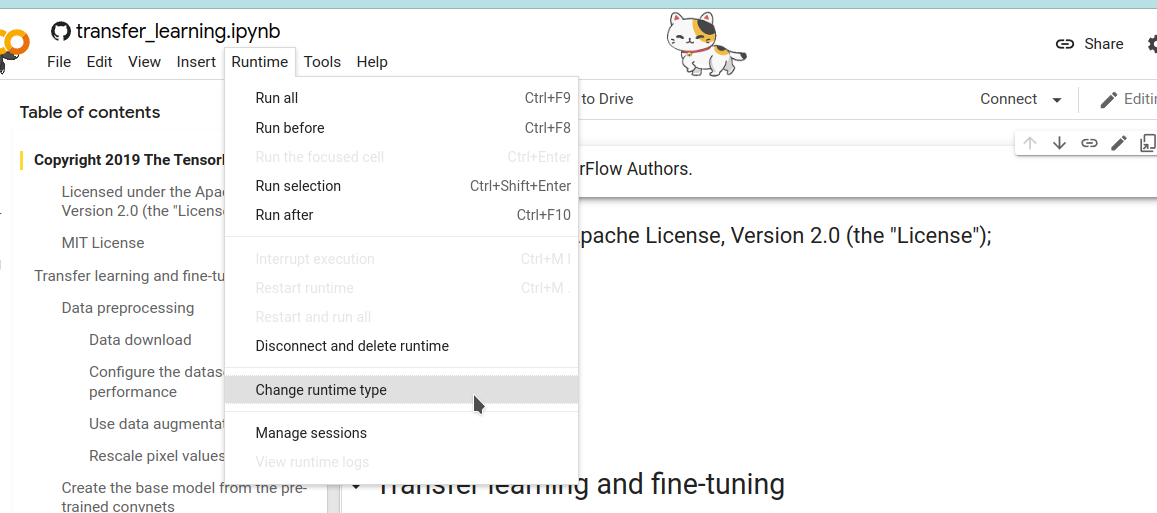

# Data loading and preprocessing

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
y_train_sparse = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_sparse = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# Baseline model

model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Normalization(),     # (0:255) -> (-1:1)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
# Read the docs https://keras.io/getting_started/ or 
?model.compile

### Проверяем работу модели, переобучив на малой выборке

In [ ]:
model.fit(x_train[:200], y_train_sparse[:200], epochs=20)

### **Вопрос 1.** Почему начальный лосс вопреки ожиданиям намного больше 2.3?  
Ответ: 

In [ ]:
# Two layers with BatchNormalization

model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Normalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [ ]:
# Add metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Add validation
history = model.fit(x_train, y_train_sparse, validation_split=0.2, epochs=10)

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.subplot(1,2,2)
plt.title('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])

In [ ]:
# Weight initialization in practice https://keras.io/api/layers/initializers/

from tensorflow.keras import layers
from tensorflow.keras import initializers

layer = layers.Dense(
    units=64,
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()
)

# All built-in initializers can also be passed via their string identifier
layer = layers.Dense(
    units=64,
    kernel_initializer='random_normal',
    bias_initializer='zeros'
)

### Задание 1.  

Добавьте в модель один сверточный слой и найдите лучшее место для слоя BatchNormalization 

In [ ]:
# Code here


### 2. Продвинутый поиск гиперпараметров

https://keras.io/keras_tuner/

In [ ]:
!pip install keras-tuner -q

In [ ]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
    # Find optimal hidden layer size
    hidden_units = hp.Int(name='hidden_units', min_value=20, max_value=200)
    
    model = keras.Sequential()
    model.add(keras.layers.Normalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hidden_units))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5)

In [ ]:
tuner.search(x_train, y_train_sparse, epochs=5, validation_data=(x_test, y_test_sparse))
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.evaluate(x_test, y_test_sparse)

### Задание 2.  

Используя модель из предыдущего задания, определите оптимальное количество сверточных фильтров с помошью keras_tuner.

In [ ]:
# Code here


### 3. Продвинутая регуляризация

In [ ]:
model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Normalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(x_train, y_train_sparse, validation_split=0.2, epochs=10)

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.subplot(1,2,2)
plt.title('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])

### Задание 3.  

Для модели с одним сверточным слоем найдите лучшее место для слоя Dropout 

In [ ]:
# Code here


### 4. Transfer learning  
https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Задание 4.  

С помощью аугментаций и/или усложнения архитектуры сети добейтесь повышения точности классификации до 0.95 на validation. 

In [ ]:
# Code here
